# Humans and Machines AutoEncoder Training Notebook

### Table of Contents
* Introduction
* Dataset
* Training
* References

#### Introduction

AWS accounts and usernames used for service accounts(machines) doing automated activities show different behaviours than accounts used by humans. Therefore, when such accounts are compromised, their CloudTrail logs change behaviour. AWS CloudTrail monitors activity across the AWS infrastructure. More information on AWS CloudTrail can be found [here](https://aws.amazon.com/cloudtrail/).

This notebook shows how to train a neural network to learn the patterns in CloudTrail logs of AWS Accounts. We use an autoencoder and try to reconstruct the CloudTrail logs. 
An autoencoder is a neural network that can be used to learn a compressed representation of data. An autoencoder has encoder and decoder parts. The encoder compresses the data into a smaller dimension, and the decoder attempts to reconstruct the input. More information on the dfencoder library can be found [here](https://github.com/AlliedToasters/dfencoder).

In inference, unusual logs should have a higher reconstruction error. 

#### Dataset
The dataset we use is the AWS CloudTrail logs in a tabular format consisting of the features we use. 

In [1]:
import pandas as pd
import os
import numpy as np
import glob
import torch
from morpheus.models.dfencoder import AutoEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import dill

Reading the benign training data and test data that contain anomalies

In [2]:
TRAINING_DATA_PATH = "../../datasets/training-data/dfp-cloudtrail-user123-training-data.csv"
VAL_DATA_PATH = "../../datasets/validation-data/dfp-cloudtrail-user123-validation-data-input.csv"
OUTPUT_MODEL_NAME = "hammah-user123-20211017.pkl"

In [3]:
# uncomment to train on other "role-g" instead of "user123"

# TRAINING_DATA_PATH = "../datasets/training-data/hammah-role-g-training-data.csv"
# VAL_DATA_PATH = "../datasets/validation-data/hammah-role-g-validation-data.csv"
# OUTPUT_MODEL_NAME = "hammah-role-g-20211017.pkl"

In [4]:
X_train=pd.read_csv(TRAINING_DATA_PATH)
X_val=pd.read_csv(VAL_DATA_PATH)

Selecting the features

In [5]:
features=['eventSource', 'eventName', 'sourceIPAddress', 'userAgent','userIdentitytype', 'requestParametersroleArn', 'requestParametersroleSessionName','requestParametersdurationSeconds', 'responseElementsassumedRoleUserassumedRoleId','responseElementsassumedRoleUserarn', 'apiVersion', 'userIdentityprincipalId','userIdentityarn', 'userIdentityaccountId', 'userIdentityaccessKeyId','userIdentitysessionContextsessionIssuerprincipalId', 'userIdentitysessionContextsessionIssueruserName','tlsDetailsclientProvidedHostHeader', 'requestParametersownersSetitems','requestParametersmaxResults', 'requestParametersinstancesSetitems','errorCode', 'errorMessage', 'requestParametersmaxItems','responseElementsrequestId', 'responseElementsinstancesSetitems','requestParametersgroupSetitems', 'requestParametersinstanceType','requestParametersmonitoringenabled', 'requestParametersdisableApiTermination','requestParametersebsOptimized', 'responseElementsreservationId', 'requestParametersgroupName'] #NO userIdentitysessionContextsessionIssuerarn,userIdentityuserName

In [6]:
for i in list(X_train):
    if i not in features:
        X_train=X_train.drop(i,axis=1)
for i in list(X_val):
    if i not in features:
        X_val=X_val.drop(i,axis=1)

Data types of the fields

In [7]:
X_train.dtypes

userIdentityaccountId                              object
eventSource                                        object
eventName                                          object
sourceIPAddress                                    object
userAgent                                          object
userIdentitytype                                   object
apiVersion                                         object
userIdentityprincipalId                            object
userIdentityarn                                    object
userIdentityaccessKeyId                            object
tlsDetailsclientProvidedHostHeader                 object
errorCode                                          object
errorMessage                                       object
userIdentitysessionContextsessionIssueruserName    object
dtype: object

Making sure there's no completely empty columns in the training and validation sets

In [8]:
X_train = X_train.dropna(axis=1, how='all')
X_val = X_val.dropna(axis=1, how='all')

In [9]:
for i in list(X_val):
    if i not in list(X_train):
        X_val=X_val.drop([i],axis=1)

In [10]:
for i in list(X_train):
    if i not in list(X_val):
        X_train=X_train.drop([i],axis=1)

Configuring an autoencoder.
More details about the model and the parameters can be found [here](https://github.com/AlliedToasters/dfencoder)


In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
model = AutoEncoder(
    encoder_layers = [512, 500], #layers of the encoding part
    decoder_layers = [512], #layers of the decoding part
    activation='relu', #activation function
    swap_p=0.2, #noise parameter
    lr = 0.01, # learning rate
    lr_decay=.99, # learning decay
    batch_size=512,
    logger='ipynb', 
    verbose=False,
    optimizer='sgd', #SGD optimizer is selected(Stochastic gradient descent)
    scaler='gauss_rank', #feature scaling method
    min_cats=1 #cut off for minority categories
)

Train the model

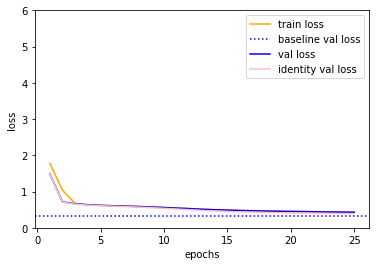

In [12]:
model.fit(X_train, epochs=25, val=X_val)

Saving the trained model

In [13]:
torch.save(model.state_dict(),OUTPUT_MODEL_NAME)

In [14]:
with open(OUTPUT_MODEL_NAME[:-4]+'dill'+'.pkl', 'wb') as f:
    serialized_model = dill.dumps(model)
    f.write(serialized_model)

Testing the model

In [15]:
scores = model.get_anomaly_score(X_val)
X_val['anomaly_score'] = scores

In [16]:
#scores = model.get_anomaly_score(X_val)
X_val['anomaly_score'] = scores
X_val.sort_values('anomaly_score', ascending=False).head(10)

,userIdentityaccountId,eventSource,eventName,sourceIPAddress,userAgent,userIdentitytype,apiVersion,userIdentityprincipalId,userIdentityarn,userIdentityaccessKeyId,tlsDetailsclientProvidedHostHeader,errorCode,errorMessage,userIdentitysessionContextsessionIssueruserName,anomaly_score
314,Account-123456789,salas.com,DetachRolePolicy,23.19.39.232,Opera/8.23.(X11; Linux i686; da-DK) Presto/2.9...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,hooper.com,success,NaN,user123,1.670993
318,Account-123456789,salas.com,DetachRolePolicy,156.198.140.30,Opera/8.23.(X11; Linux i686; da-DK) Presto/2.9...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,hooper.com,success,NaN,user123,1.610524
315,Account-123456789,lopez-byrd.info,DeleteEverything,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,UnsupportedOperation,The specified subnet belongs to a different ac...,user123,1.506423
316,Account-123456789,lopez-byrd.info,DescribeSubnets,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,MissingAction,The input fails to satisfy the constraints spe...,user123,1.455665
317,Account-123456789,lopez-byrd.info,DescribeSubnets,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,MissingAction,The input fails to satisfy the constraints spe...,user123,1.455665
321,Account-123456789,lopez-byrd.info,DescribeSubnets,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,MissingAction,The input fails to satisfy the constraints spe...,user123,1.455665
741,Account-123456789,anderson.net,ListReadinessChecks,72.5.160.159,Mozilla/5.0 (compatible; MSIE 8.0; Windows 98;...,Root,1970-07-15,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AMV0GEBKYXVMOZWRG7PN,lester.net,success,NaN,user123,1.150055
544,Account-123456789,anderson.net,ListReadinessChecks,91.115.171.224,Mozilla/5.0 (iPad; CPU iPad OS 7_1_2 like Mac ...,Root,1970-07-15,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AMV0GEBKYXVMOZWRG7PN,lester.net,success,NaN,user123,1.146068
816,Account-123456789,anderson.net,ListReadinessChecks,72.5.160.159,Mozilla/5.0 (iPad; CPU iPad OS 4_2_1 like Mac ...,Root,1970-07-15,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AMV0GEBKYXVMOZWRG7PN,lester.net,success,NaN,user123,1.134004
476,Account-123456789,anderson.net,ListReadinessChecks,91.115.171.224,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Root,1970-07-15,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AMV0GEBKYXVMOZWRG7PN,lester.net,success,NaN,user123,1.126855


In [17]:
X_val["zscore"] = (X_val["anomaly_score"] - X_val["anomaly_score"].mean())/X_val["anomaly_score"].std()

In [18]:
X_val.sort_values('zscore', ascending=False).head(10)

,userIdentityaccountId,eventSource,eventName,sourceIPAddress,userAgent,userIdentitytype,apiVersion,userIdentityprincipalId,userIdentityarn,userIdentityaccessKeyId,tlsDetailsclientProvidedHostHeader,errorCode,errorMessage,userIdentitysessionContextsessionIssueruserName,anomaly_score,zscore
314,Account-123456789,salas.com,DetachRolePolicy,23.19.39.232,Opera/8.23.(X11; Linux i686; da-DK) Presto/2.9...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,hooper.com,success,NaN,user123,1.670993,5.653509
318,Account-123456789,salas.com,DetachRolePolicy,156.198.140.30,Opera/8.23.(X11; Linux i686; da-DK) Presto/2.9...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,hooper.com,success,NaN,user123,1.610524,5.386526
315,Account-123456789,lopez-byrd.info,DeleteEverything,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,UnsupportedOperation,The specified subnet belongs to a different ac...,user123,1.506423,4.926896
316,Account-123456789,lopez-byrd.info,DescribeSubnets,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,MissingAction,The input fails to satisfy the constraints spe...,user123,1.455665,4.702792
317,Account-123456789,lopez-byrd.info,DescribeSubnets,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,MissingAction,The input fails to satisfy the constraints spe...,user123,1.455665,4.702792
321,Account-123456789,lopez-byrd.info,DescribeSubnets,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,MissingAction,The input fails to satisfy the constraints spe...,user123,1.455665,4.702792
741,Account-123456789,anderson.net,ListReadinessChecks,72.5.160.159,Mozilla/5.0 (compatible; MSIE 8.0; Windows 98;...,Root,1970-07-15,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AMV0GEBKYXVMOZWRG7PN,lester.net,success,NaN,user123,1.150055,3.353450
544,Account-123456789,anderson.net,ListReadinessChecks,91.115.171.224,Mozilla/5.0 (iPad; CPU iPad OS 7_1_2 like Mac ...,Root,1970-07-15,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AMV0GEBKYXVMOZWRG7PN,lester.net,success,NaN,user123,1.146068,3.335850
816,Account-123456789,anderson.net,ListReadinessChecks,72.5.160.159,Mozilla/5.0 (iPad; CPU iPad OS 4_2_1 like Mac ...,Root,1970-07-15,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AMV0GEBKYXVMOZWRG7PN,lester.net,success,NaN,user123,1.134004,3.282584
476,Account-123456789,anderson.net,ListReadinessChecks,91.115.171.224,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Root,1970-07-15,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AMV0GEBKYXVMOZWRG7PN,lester.net,success,NaN,user123,1.126855,3.251018


Anomalous events if there are any, based on 4 standard deviations :

In [19]:
X_val[X_val['zscore']>4]

,userIdentityaccountId,eventSource,eventName,sourceIPAddress,userAgent,userIdentitytype,apiVersion,userIdentityprincipalId,userIdentityarn,userIdentityaccessKeyId,tlsDetailsclientProvidedHostHeader,errorCode,errorMessage,userIdentitysessionContextsessionIssueruserName,anomaly_score,zscore
314,Account-123456789,salas.com,DetachRolePolicy,23.19.39.232,Opera/8.23.(X11; Linux i686; da-DK) Presto/2.9...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,hooper.com,success,NaN,user123,1.670993,5.653509
315,Account-123456789,lopez-byrd.info,DeleteEverything,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,UnsupportedOperation,The specified subnet belongs to a different ac...,user123,1.506423,4.926896
316,Account-123456789,lopez-byrd.info,DescribeSubnets,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,MissingAction,The input fails to satisfy the constraints spe...,user123,1.455665,4.702792
317,Account-123456789,lopez-byrd.info,DescribeSubnets,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,MissingAction,The input fails to satisfy the constraints spe...,user123,1.455665,4.702792
318,Account-123456789,salas.com,DetachRolePolicy,156.198.140.30,Opera/8.23.(X11; Linux i686; da-DK) Presto/2.9...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,hooper.com,success,NaN,user123,1.610524,5.386526
321,Account-123456789,lopez-byrd.info,DescribeSubnets,200.228.121.182,Mozilla/5.0 (Windows; U; Windows 98) AppleWebK...,Root,NaN,c605fd31-b71e-4385-a9c9-1cfc259fcbe1,arn:aws:8ab33856-b311-4fa8-bab1-2a7fad0ec33d,AZM8CDAQJ8EN63D9DV3H,NaN,MissingAction,The input fails to satisfy the constraints spe...,user123,1.455665,4.702792


### Conclusion
Individual models can be trained for different users or roles. Other log types that can be represented in tabular format can also be used to learn the patterns and detect anomalous ones. Because the training is unsupervised, the users do not need to label their dataset. In production, the reconstruction loss should be calculated over a period of time where there are no substantial attacks on the network. Once a mean value for the reconstruction loss is determined, the CloudTrail logs that are two or more standard deviations away from the mean can be marked as anomalies.
### References
https://github.com/AlliedToasters/dfencoder

https://aws.amazon.com/cloudtrail/